http://mooc.study.163.com/course/2001281002#/info

感谢吴恩达老师，这是我见过最好的 DNN 课程。<br>
学完这们课程之后，再去看Ian那本著名《深度学习》就知道他在讲什么了。

理解DNN之后，代码实现真不是个事。我把我的代码分享出来，希望能对其他同学有帮助。

欢迎加我QQ，别忘了说你是这门课的同学。

昵称：49<br>QQ：2055610 <br>邮箱：2055610@qq.com

In [1]:
import numpy as np

# 1. 准备工作

## 1.1 dict 升级

为了使得后边的代码更简洁易懂，我在这里重载了dict的方法，使它支持用整数（int）直接当作key。

In [2]:
from collections import defaultdict
class Ea(defaultdict):
    def __setattr__(self, name, value):
        super(Ea, self).__setitem__(name, value)

## 1.2 准备好常用激活函数及其导数函数

In [3]:
# Active Functions
def linear(z):
    return z
def dz_linear(z):
    return 1

def sigmoid(z):
    g = 1 / (1 + np.exp(-z))
    return g

def dz_sigmoid(z):
    s = sigmoid(z)
    dz = s * (1-s)
    return dz

def tanh(z):
    return np.tanh(z)

def dz_tranh(z):
    t = tanh(z)
    dz = 1-t**2
    return dz

def relu(z):
    g = np.fmax(z, 0)
    return g

def dz_relu(z):
    g = np.fmax(z,0)
    g = np.sign(g)
    return g

def leaky_relu(z):
    g = np.fmax(z, 0.01*z)
    return g

def dz_leaky_relu(z):
    g = np.piecewise(z, [z < 0, z > 0], [.01, 1])
    return g

## 1.3 常用损失函数及其导函数

In [4]:
# Cost Functions
def L1(A, Y):
    loss = np.sum(np.abs(A-Y))
    loss = np.squeeze(loss)
    return loss

def dA_L1(A,Y):
    return np.sign(A-Y)

def L2(A, Y):
    loss = 1/2 * np.dot((A-Y), (A-Y).T)
    loss = np.squeeze(loss)
    return loss

def dA_L2(A,Y):
    return A-Y

def L3(A, Y):
    m = Y.shape[0]
    loss = -1 / m * np.sum(Y * np.log(A) + (1-Y) * np.log(1-A), axis=1, keepdims=True)
    loss = np.squeeze(loss)
    assert (loss.shape == ())
    return loss

def dA_L3(A,Y):
    loss = -Y/A + (1-Y)*np.log(1-A)
    loss = np.squeeze(loss)
    return loss

## 1.4 准备一个线性回归的测试数据，增加一些噪音

学习一个线性模型，对DNN来说可能大材小用。但可帮助理解DNN是怎么工作的。

In [5]:
# Data 
def sX(w,b,m):
    nx = len(w)
    X = np.random.normal(size=(nx, m))
    Y = np.dot(w, X) + b
    noise = .01 * np.random.normal(size=Y.shape)
    print(L2(noise,0))
    Y += noise
    return X, Y

# Data X    Target Y
true_w = [2, -3.4,5]
true_b = [4.2]
m = 1000
X,Y = sX(true_w, true_b, m)

0.0535784402332


# 2.深层神经网络实现
## 2.1 初始化“超参”、定义网络结构

In [6]:
# Hyperparameters
L = 4 # 神经网络层数 
learn_rate = 0.02 # 学习率 （有些书里，学习率用alpha表示）
iterators = 5000  # 迭代次数

n = Ea()
n[0] = X.shape[0] # 第0层是输入层。
n[1] = 4 # 第1层 4 个节点
n[2] = 4 # 第2层 4 个节点
n[3] = 4 # 第3层 4 个节点
n[4] = 1 # 第4层 1 个节点
n[L] = 1 # 强制输出层 1 个节点

g = Ea() # 分层定义激活函数
g[1] = linear
g[2] = linear
g[3] = linear
g[4] = linear

dg = Ea() # 分层定义激活导函数
dg[1] = dz_linear
dg[2] = dz_linear
dg[3] = dz_linear
dg[4] = dz_linear

loss = L2 # 定义成本函数
dA_loss = dA_L2 # 定义成本导函数

这里使用了Ea，g[1]=linear 相当于向dict里存了一个函数的索引（指针）。是不是很方便?

我们的Demo数据是一个线性模型，所以激活函数和导函数用linear和dz_linear<br>
其实你发现，用relu也可以，但学习速度慢，且误差大，你可以考虑为什么？<br>
L=1 相当于线性回归，你可以试试。<br>
用 L1, dA_L1 作为成本函数及其导函数试试，看看结果会怎么样？


## 2.2 随机初始化参数 W，b

随机初始化参数的说法，有些误导性。<br>
你会发现，我们需要的是有策略的随机。我们要有策略的”撞大运“<br>

希望你能理解，什么叫有策略的“撞大运”<br>
这点十分重要。这甚至是神经网络的一个研究方向<br>

我这里简单的使用 np.random.normal(一组符合正态分布的随机数）并控制在(-P,P)<br>
建议你p=0.01试试，看看会怎么样？

In [7]:
# Parameters W,b
W=Ea()
b=Ea()
p = 0.1
for l in range(1,L+1):
    W[l] = (2 * np.random.normal(size=(n[l], n[l - 1])) - 1) * p
    b[l] = np.zeros(shape=(n[l], 1))

## 2.3 深层网络的迭代实现
因为使用了Ea，代码就能像课程里的伪代码一样简洁。（感慨一下 python 的便利）

In [8]:
Z = Ea(); A = Ea()
A[0]=X
dZ=Ea();dA=Ea();dW=Ea();db=Ea()
output_cost = []

for iter in range(1,iterators):
    # forward properation
    for l in range(1,L+1):
        Z[l] = np.dot(W[l], A[l - 1]) + b[l]
        A[l] = g[l](Z[l])

    cost = loss(A[L],Y)    
    output_cost.append(cost)
    dA[L] = dA_loss(A[L], Y)
    
    # back properation
    for l in range(0,L):
        l = L-l
        dZ[l] = dA[l] * dg[l](Z[l])
        dA[l-1] = np.dot(W[l].T,dZ[l])
        dW[l] = 1/m * np.dot(dZ[l],A[l-1].T)
        db[l] = 1/m * np.sum(dZ[l],axis=1, keepdims=True)

    # update parameters
    for l in range(0,L):
        l = L-l
        W[l] = W[l] - learn_rate * dW[l]
        b[l] = b[l] - learn_rate * db[l]
        
print("Final Cost:",cost)
print("true_w:",true_w)
print("W:",W[1])
print("true_b:",true_b)
print("b:",b[1])

Final Cost: 0.053364955914849875
true_w: [2, -3.4, 5]
W: [[-0.27951217  0.5187474  -0.6310378 ]
 [ 0.19093557 -0.43347438  0.76496814]
 [ 0.35205615 -0.38327213  0.26182662]
 [ 0.19211259 -0.33301966  0.68121513]]
true_b: [4.2]
b: [[-0.03128255]
 [ 0.07006918]
 [ 0.11231595]
 [ 0.09451161]]


## 2.4 绘制代价函数，观察学习效果

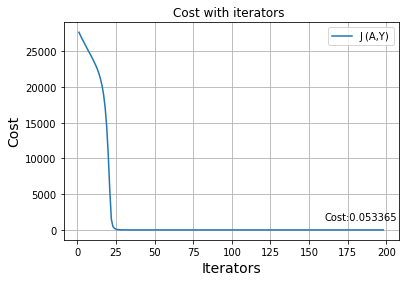

In [9]:
import matplotlib.pyplot as plt
plt.title("Cost with iterators ")
plt.grid(True)
wd = 200
plt.plot(range(1,wd-1),output_cost[1:wd-1],label='J (A,Y)')
plt.ylabel("Cost",fontsize=14)
plt.xlabel("Iterators",fontsize=14)
plt.text(wd*.8,output_cost[0]*.05,"Cost:%f" % cost)
plt.legend()
plt.show()